In [4]:
import json
import math
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import losses, optimizers, metrics
import numpy as np
from tensorflow.keras.optimizers import schedules

Using TensorFlow backend


In [2]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 42.1 MB/s eta 0:00:00


In [3]:
!pip install keras

In [5]:
classifier = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet_classifier"
)

29137304/29137304 [==============================] - 0s 0us/step


In [21]:
filepath = tf.keras.utils.get_file(origin="https://i.imgur.com/9i63gLN.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)
#keras_cv.visualization.plot_image_gallery([image], value_range=(0, 255))

In [14]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 [==============================] - 3s 3s/step


In [15]:
top_classes = predictions[0].argsort(axis=-1)

In [16]:
classes = keras.utils.get_file(origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json")

with open(classes, "rb") as f:
  classes = json.load(f)

33567/33567 [==============================] - 0s 0us/step


In [17]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are: ", top_two)

Top two classes are:  ['Egyptian cat', 'velvet']


In [ ]:
#FINE TUNING A PRE-TRAINED CLASSIFIER

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


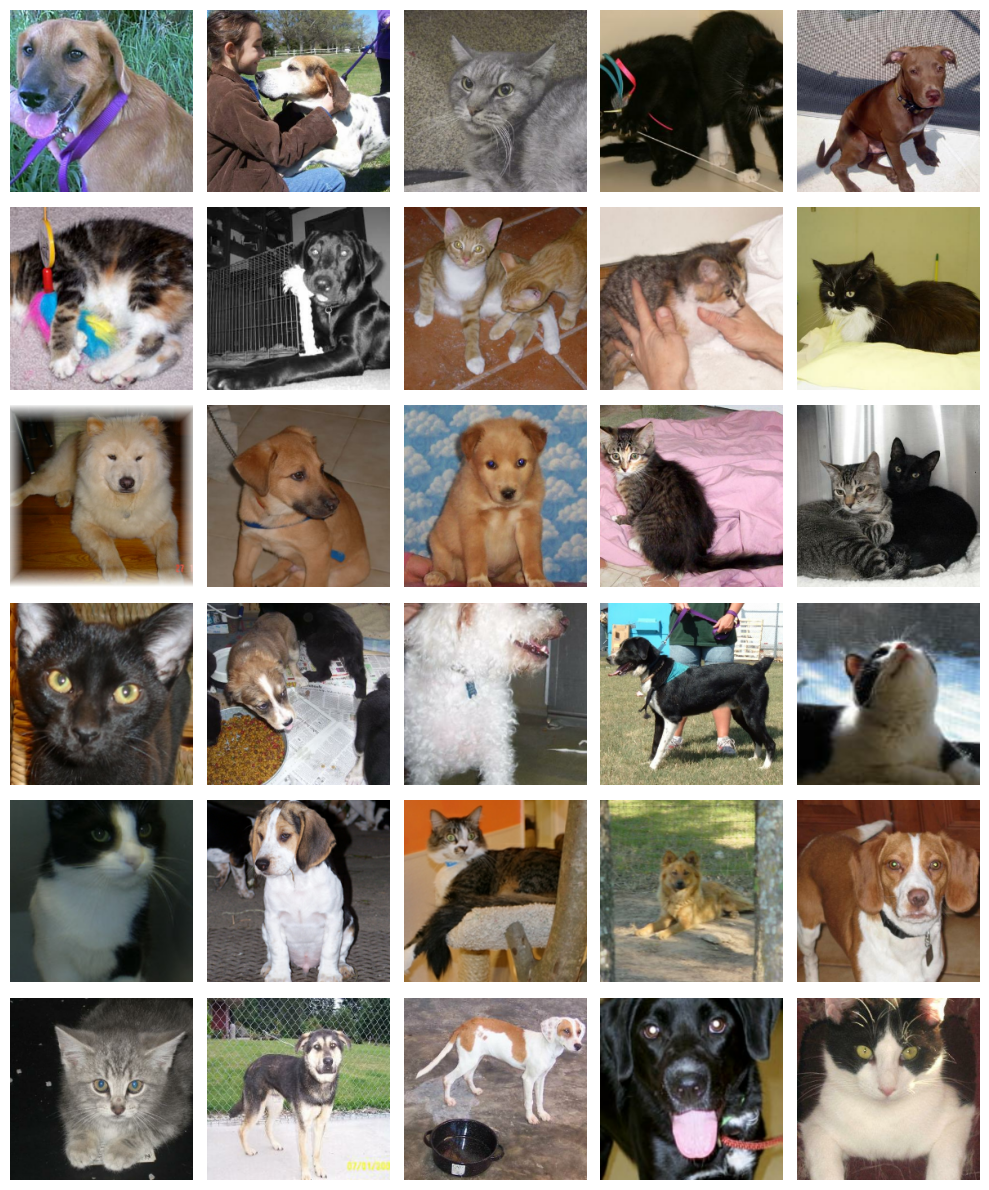

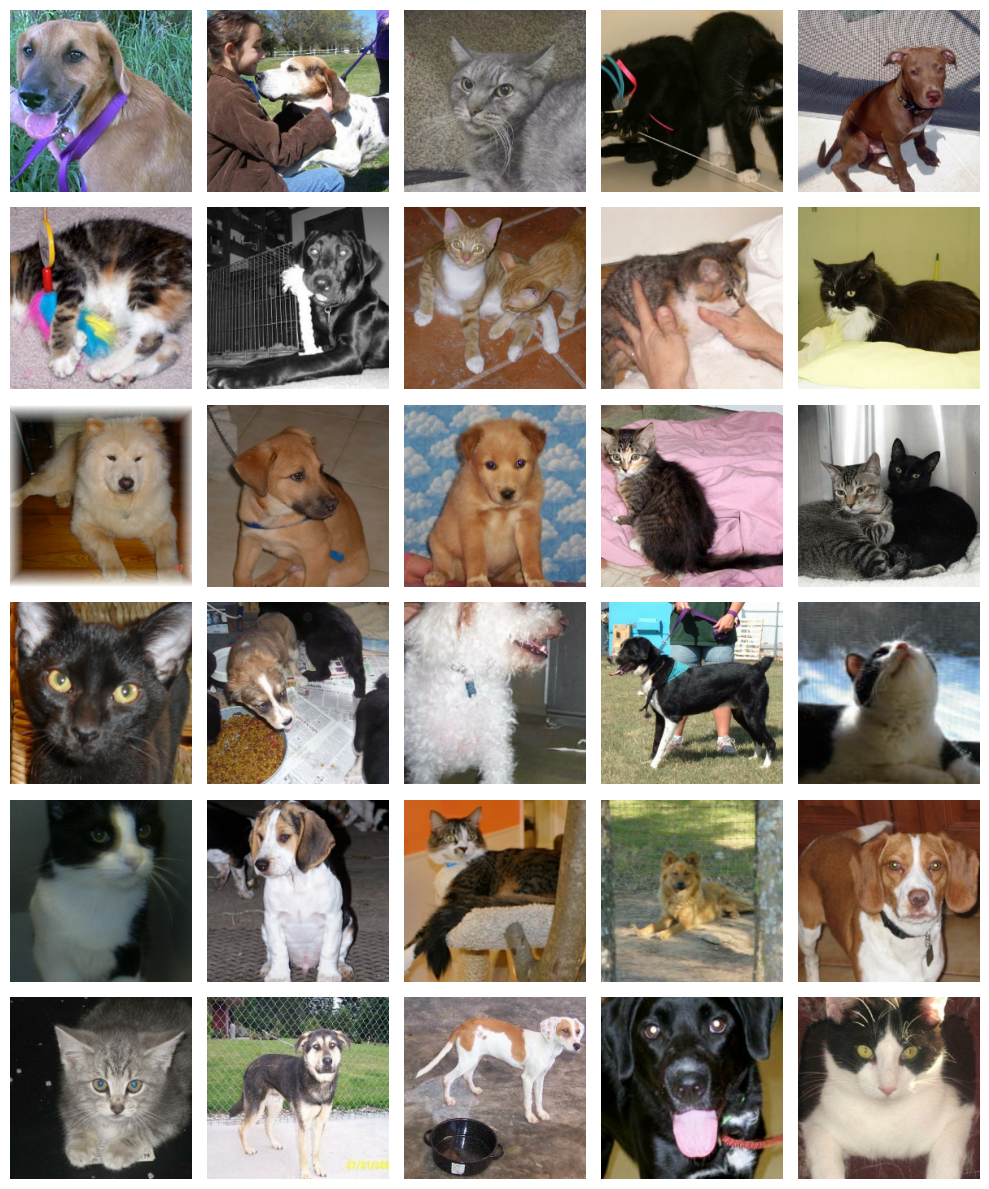

In [22]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [23]:
model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

24029184/24029184 [==============================] - 0s 0us/step


In [24]:
model.fit(train_dataset)

 61/727 [=>............................] - ETA: 1:19:50 - loss: 0.5833 - accuracy: 0.7802

KeyboardInterrupt: ignored

In [25]:
predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 [==============================] - 3s 3s/step
Top class is: cat
